# Align and Plot Source Image on Destination Coordinates with SIFT

In [1]:
from pycodex import metadata, io, align
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import os
import pickle as pkl

import importlib
importlib.reload(align)

io.setup_gpu("0,1,2,3")

2024-10-27 01:42:00,181 - INFO - Using GPU(s): ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3']


# 00. Main Parameters

In [2]:
########################################################################################################################
# Directory for reference images (destination images)
dst_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw01"

# Directory for images to align on the reference images (source images)
src_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw02"

# Directory for paramters output
output_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi_demo"
########################################################################################################################

If the directories for the destination and source images are valid, a "Summary of Markers" will be printed. 

In [3]:
# destination images
dst_metadata_dict = io.organize_metadata_fusion(dst_dir, subfolders=False)
dst_unique_markers, _, _, _ = metadata.summary_markers(dst_metadata_dict)

Summary of Markers:
- Total unique markers: 20
- Unique markers: 20 ['BCL-xL', 'BCL6', 'CD11b', 'CD11c', 'CD169', 'CD19', 'CD31', 'CD4', 'CD45', 'CD79B', 'CD8', 'DAPI', 'HPV-E6', 'HPV-E7', 'TCRg_d', 'mTOR', 'p4EBP1', 'pCastor1', 'pS6', 'pSTAT3']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []



In [4]:
# source images
src_metadata_dict = io.organize_metadata_fusion(src_dir, subfolders=False)
src_unique_markers, _, _, _ = metadata.summary_markers(src_metadata_dict)

Summary of Markers:
- Total unique markers: 18
- Unique markers: 18 ['CD127', 'CD163', 'CD20-B220', 'CD3', 'CD335', 'CD68', 'DAPI', 'F4-80', 'FOXO1', 'Foxp3', 'GranzymeB', 'H2Kb', 'Hexokinase1', 'Ki67', 'Ly6C', 'TCF1_7', 'cCaspase3', 'pAKT']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []



Check the files within the output directory. 

In [5]:
!ls $output_dir

sift_parameter.pkl


# 01. Data Overview

In [6]:
# Common markers in both destination and soruce images
[marker for marker in dst_unique_markers if marker in src_unique_markers]

['DAPI']

In [7]:
########################################################################################################################
# Select a common marker of source and destination imges for SIFT alignment
marker_file = "DAPI.tiff"
########################################################################################################################

im_dst = tifffile.imread(os.path.join(dst_dir, marker_file))
im_src = tifffile.imread(os.path.join(src_dir, marker_file))

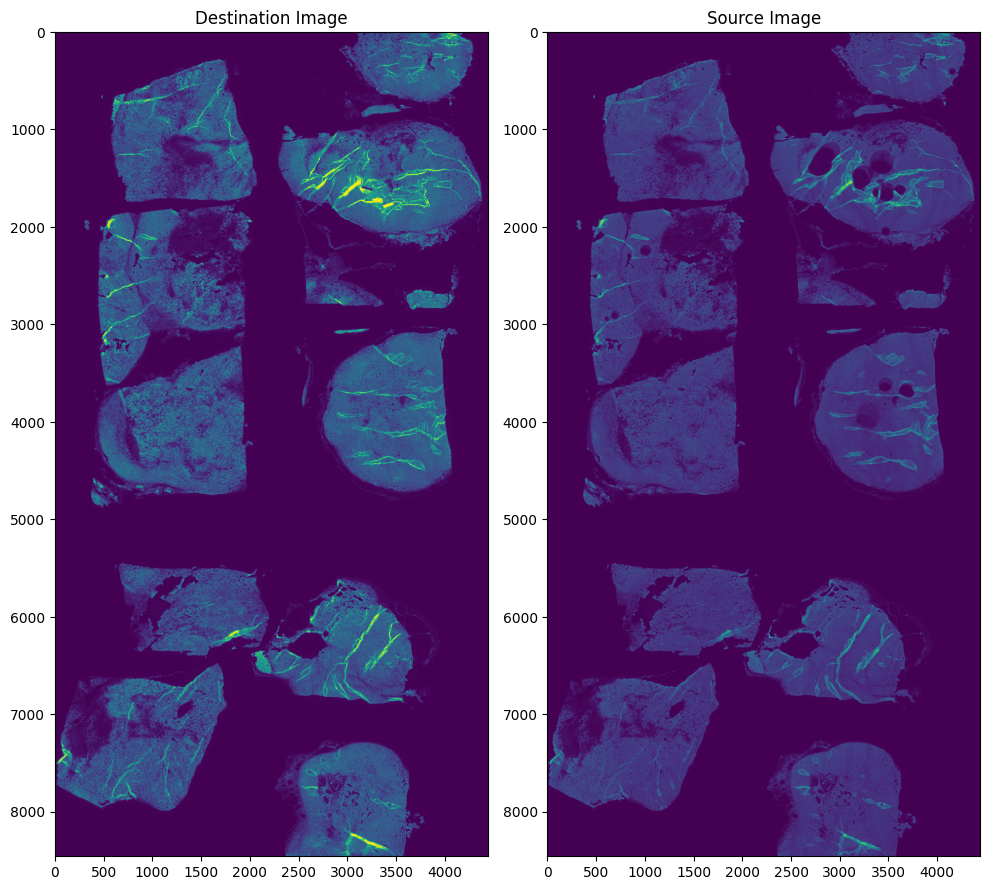

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs = axs.flatten()

axs[0].imshow(im_dst[::8, ::8])
axs[0].set_title("Destination Image")

axs[1].imshow(im_src[::8, ::8])
axs[1].set_title("Source Image")

plt.tight_layout()
plt.show()

# 02. SIFT Alignment

In [9]:
sift_matcher = align.SIFTMatcher(im_src, im_dst, step=8)

Initialize SIFT detector
Find keypoints and descriptors
Initialize matcher
Match descriptors


This intersection percentages plot assists in selecting an appropriate Lowe’s ratio threshold for SIFT alignment. 

For two images with minimal rotation (as in our case, where there is no rotation between the two images), a lower intersection percentage indicates better alignment performance.

100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


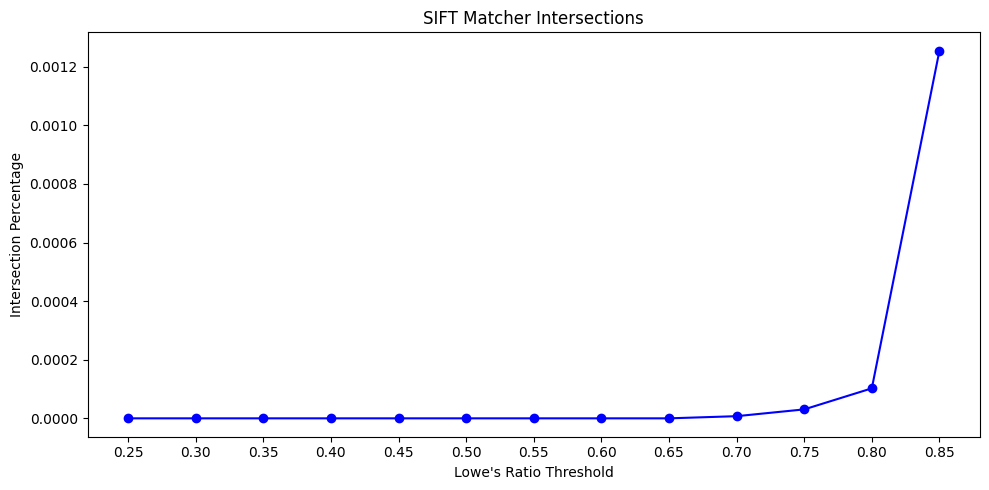

In [10]:
sift_matcher.find_kp_intersections()
sift_matcher.plot_kp_intersections(figsize=(10, 5))

Apply Lowe's ratio threshold


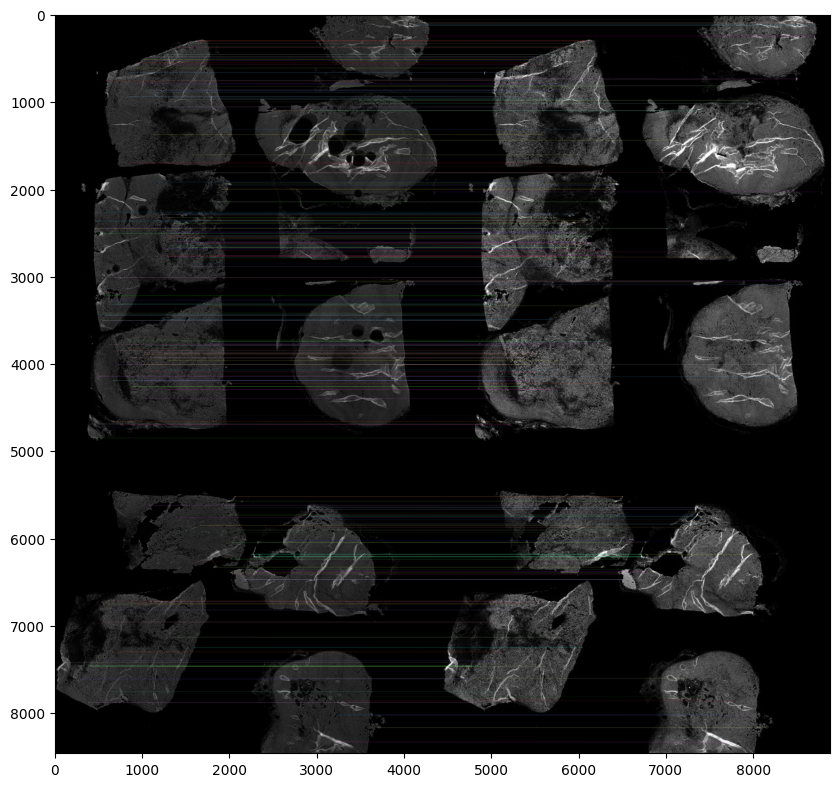

In [11]:
########################################################################################################################
# Set appropriate Lowe's ratio threshold
ratio_threshold = 0.50
########################################################################################################################

sift_matcher.set_lowe_ratio_threshold(ratio_threshold, figsize=(10, 10))

In [12]:
H, H_inverse = sift_matcher.compute_affine_matrix()
im_src_trans, blank_mask = align.apply_affine_transformation(im_src, im_dst.shape, H_inverse)

Extract matched keypoints
Compute affine transformation


In [13]:
# percentage of non-overlap region
f"masked percentage (%): {np.mean(blank_mask) * 100}"

'masked percentage (%): 0.018159823719996592'

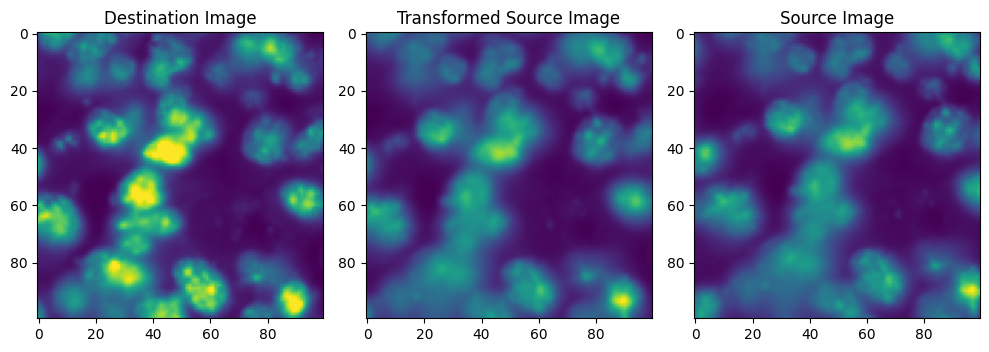

In [14]:
########################################################################################################################
# Select an appropriate region to check the SIFT alignment performance
x_beg = 8000
y_beg = 8000
length = 100
########################################################################################################################

im_dst_sm = im_dst[y_beg : (y_beg + length), x_beg : (x_beg + length)]
im_src_trans_sm = im_src_trans[y_beg : (y_beg + length), x_beg : (x_beg + length)]
im_src_sm = im_src[y_beg : (y_beg + length), x_beg : (x_beg + length)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
axs = axs.flatten()

axs[0].imshow(im_dst_sm)
axs[0].set_title("Destination Image")

axs[1].imshow(im_src_trans_sm)
axs[1].set_title("Transformed Source Image")

axs[2].imshow(im_src_sm)
axs[2].set_title("Source Image")

plt.tight_layout()
plt.show()

# 03. Parameter Export

In [15]:
os.makedirs(output_dir, exist_ok=True)
data = {"H_inverse": H_inverse, "blank_mask": blank_mask, "output_shape": im_dst.shape}

output_path = os.path.join(output_dir, "sift_parameter.pkl")
if os.path.exists(output_path):
    print(f"File already exists: {output_path}.")
else:
    with open(output_path, "wb") as f:
        pkl.dump(data, f)

File already exists: /mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi_demo/sift_parameter.pkl.


# 04. Final Check for Main Parameters

In [16]:
print(f"dst_dir = '{dst_dir}'\n" f"src_dir = '{src_dir}'\n" f"output_dir = '{output_dir}'\n")

dst_dir = '/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw01'
src_dir = '/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw02'
output_dir = '/mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi_demo'



The parameters between the ‘#’ lines are the ones that need to be modified for each run of the alignment script.

In [17]:
########################################################################################################################

dst_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw01"
src_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw02"
output_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi_demo"

########################################################################################################################

In [18]:
# test image folders
dst_metadata_dict = io.organize_metadata_fusion(dst_dir, subfolders=False)
dst_unique_markers, _, _, _ = metadata.summary_markers(dst_metadata_dict)
src_metadata_dict = io.organize_metadata_fusion(src_dir, subfolders=False)
src_unique_markers, _, _, _ = metadata.summary_markers(src_metadata_dict)

# test output folder
!ls $output_dir

Summary of Markers:
- Total unique markers: 20
- Unique markers: 20 ['BCL-xL', 'BCL6', 'CD11b', 'CD11c', 'CD169', 'CD19', 'CD31', 'CD4', 'CD45', 'CD79B', 'CD8', 'DAPI', 'HPV-E6', 'HPV-E7', 'TCRg_d', 'mTOR', 'p4EBP1', 'pCastor1', 'pS6', 'pSTAT3']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []

Summary of Markers:
- Total unique markers: 18
- Unique markers: 18 ['CD127', 'CD163', 'CD20-B220', 'CD3', 'CD335', 'CD68', 'DAPI', 'F4-80', 'FOXO1', 'Foxp3', 'GranzymeB', 'H2Kb', 'Hexokinase1', 'Ki67', 'Ly6C', 'TCF1_7', 'cCaspase3', 'pAKT']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []

sift_parameter.pkl
